In [1]:
from PIL import Image

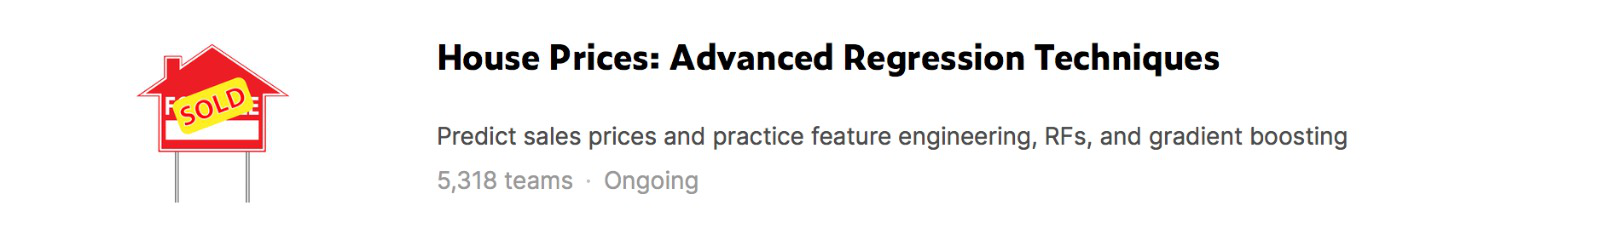

In [2]:
Image.open('./House.jpeg')

In [3]:
import findspark
findspark.init()
findspark.find()
import pyspark
findspark.find()
from pyspark import SparkContext
sc=SparkContext(master="local[3]")
print(sc)
from pyspark.sql.session import SparkSession
spark = SparkSession.builder.appName("spark_airport").getOrCreate()

<SparkContext master=local[3] appName=pyspark-shell>


In [4]:
from pyspark.ml import Pipeline
from pyspark.mllib.linalg import Vectors
from pyspark.ml.feature import VectorAssembler,HasHandleInvalid
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import RandomForestRegressionModel, RandomForestRegressor
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import GBTRegressionModel, GBTRegressor
import pyspark.ml.feature as ft
import pyspark.sql.types as typ
import pyspark.mllib.stat as st


In [5]:
midata = spark.read.csv('./train.csv', header = 'true', inferSchema = 'true', sep = ','  ) 

Hacemos un cast de tipo Double a nuestra variable objetivo 

In [6]:

midata = midata.withColumn('SalePrice', midata['SalePrice'].cast(typ.DoubleType()))


Imprimimos el esquema para verificar que se han modificado

In [7]:
midata.printSchema()

root
 |-- Id: integer (nullable = true)
 |-- MSSubClass: integer (nullable = true)
 |-- MSZoning: string (nullable = true)
 |-- LotFrontage: string (nullable = true)
 |-- LotArea: integer (nullable = true)
 |-- Street: string (nullable = true)
 |-- Alley: string (nullable = true)
 |-- LotShape: string (nullable = true)
 |-- LandContour: string (nullable = true)
 |-- Utilities: string (nullable = true)
 |-- LotConfig: string (nullable = true)
 |-- LandSlope: string (nullable = true)
 |-- Neighborhood: string (nullable = true)
 |-- Condition1: string (nullable = true)
 |-- Condition2: string (nullable = true)
 |-- BldgType: string (nullable = true)
 |-- HouseStyle: string (nullable = true)
 |-- OverallQual: integer (nullable = true)
 |-- OverallCond: integer (nullable = true)
 |-- YearBuilt: integer (nullable = true)
 |-- YearRemodAdd: integer (nullable = true)
 |-- RoofStyle: string (nullable = true)
 |-- RoofMatl: string (nullable = true)
 |-- Exterior1st: string (nullable = true)
 |--

In [8]:
Cols = ['SalePrice','TotalBsmtSF','PoolArea',
                'MSSubClass','LotArea','OverallQual','OverallCond',
                'YearBuilt','YearRemodAdd',
                'BsmtFinSF1','BsmtFinSF2', 'BsmtUnfSF','YrSold','1stFlrSF', '2ndFlrSF', 'LowQualFinSF','GrLivArea',
                'BsmtFullBath','BsmtHalfBath','FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
                'Fireplaces','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch',
                'ScreenPorch','PoolArea','MiscVal','MoSold'
               ]
          

In [9]:
rdd = midata\
                       .select(Cols)\
                       .rdd \
                       .map(lambda row: [e for e in row])

In [10]:
corrs = st.Statistics.corr(rdd)

for i, el in enumerate(corrs > 0.5):
    correlated = [
        (Cols[j], corrs[i][j]) 
        for j, e in enumerate(el) 
        if e == 1.0 and j != i]
    
    if len(correlated) > 0:
        for e in correlated:
            print('{0}-to-{1}: {2:.2f}' \
                  .format(Cols[i], e[0], e[1]))

SalePrice-to-TotalBsmtSF: 0.61
SalePrice-to-OverallQual: 0.79
SalePrice-to-YearBuilt: 0.52
SalePrice-to-YearRemodAdd: 0.51
SalePrice-to-1stFlrSF: 0.61
SalePrice-to-GrLivArea: 0.71
SalePrice-to-FullBath: 0.56
SalePrice-to-TotRmsAbvGrd: 0.53
SalePrice-to-GarageCars: 0.64
SalePrice-to-GarageArea: 0.62
TotalBsmtSF-to-SalePrice: 0.61
TotalBsmtSF-to-OverallQual: 0.54
TotalBsmtSF-to-BsmtFinSF1: 0.52
TotalBsmtSF-to-1stFlrSF: 0.82
PoolArea-to-PoolArea: 1.00
OverallQual-to-SalePrice: 0.79
OverallQual-to-TotalBsmtSF: 0.54
OverallQual-to-YearBuilt: 0.57
OverallQual-to-YearRemodAdd: 0.55
OverallQual-to-GrLivArea: 0.59
OverallQual-to-FullBath: 0.55
OverallQual-to-GarageCars: 0.60
OverallQual-to-GarageArea: 0.56
YearBuilt-to-SalePrice: 0.52
YearBuilt-to-OverallQual: 0.57
YearBuilt-to-YearRemodAdd: 0.59
YearBuilt-to-GarageCars: 0.54
YearRemodAdd-to-SalePrice: 0.51
YearRemodAdd-to-OverallQual: 0.55
YearRemodAdd-to-YearBuilt: 0.59
BsmtFinSF1-to-TotalBsmtSF: 0.52
BsmtFinSF1-to-BsmtFullBath: 0.65
1stFlrSF

Creamos nuestro VectorAssembler

In [11]:
featuresCreator =VectorAssembler( inputCols=["YearBuilt","TotalBsmtSF","OverallQual","GrLivArea","GarageArea"],outputCol='features')

Segmentamos nuestros datos en:


Datos de Entrenamiento (train_data)

Datos de Test(test_data)

In [12]:
train_data,test_data=midata.randomSplit([0.80,0.20])

# Regresion Lineal

Definimos la regresión y el Pipeline

In [79]:
lr=LinearRegression(featuresCol='features',labelCol='SalePrice')
pipeline = Pipeline(stages=[featuresCreator, lr])

Entrenamos el modelo 

In [80]:
modelL= pipeline.fit(train_data)

In [82]:
predictionsL = modelL.transform(train_data)

Imprimimos 20 registros para ver a groso modo que tal predice nuestro modelo de Regresion Lineal

In [83]:
predictionsL.select("prediction", "SalePrice", "features").show()

+------------------+---------+--------------------+
|        prediction|SalePrice|            features|
+------------------+---------+--------------------+
|172388.74473247863| 181500.0|[1976.0,1262.0,6....|
|226419.49617906776| 223500.0|[2001.0,920.0,7.0...|
| 191609.4573055664| 140000.0|[1915.0,756.0,7.0...|
|  285936.828320496| 250000.0|[2000.0,1145.0,8....|
|147706.68876737333| 143000.0|[1993.0,796.0,5.0...|
|268651.54309900897| 307000.0|[2004.0,1686.0,8....|
|233795.88808752294| 200000.0|[1973.0,1107.0,7....|
|198531.10638521786| 129900.0|[1931.0,952.0,7.0...|
|125099.37015887338| 129500.0|[1965.0,1040.0,5....|
|313631.16249630274| 345000.0|[2005.0,1175.0,9....|
|112417.00560004346| 144000.0|[1962.0,912.0,5.0...|
|238769.31350916473| 279500.0|[2006.0,1494.0,7....|
|150542.00994628575| 132000.0|[1929.0,832.0,7.0...|
|150215.64309334802| 149000.0|[1970.0,1004.0,6....|
| 91458.29782838386|  90000.0|[1967.0,0.0,4.0,1...|
|134573.72275273828| 139000.0|[1958.0,1029.0,5....|
| 297926.445

### Evaluacion del modelo de Regresión Lineal

Creamos un evaluador 

In [84]:
evaluator = RegressionEvaluator(labelCol='SalePrice', predictionCol='prediction', metricName='rmse')

Error cuadratico medio mide el promedio de los errores al cuadrado, es decir, la diferencia entre el estimador y lo que se estima

In [85]:
mse = evaluator.evaluate(predictionsL, {evaluator.metricName: "rmse"})
print("MSE: %.3f" % mse)

MSE: 39017.364


El coeficiente de determinacion determina la calidad del modelo para Predecir los resultados

In [86]:
r2 = evaluator.evaluate(predictionsL, {evaluator.metricName: "r2"})
print("r2: %.3f" %r2)

r2: 0.770


# Random forest regression

Definimos la Regresión y el Pipeline

In [20]:
rf =RandomForestRegressor( labelCol='SalePrice' ,featuresCol='features' )
pipeline = Pipeline(stages=[ featuresCreator, rf])

Entrenamos el modelo

In [21]:
model = pipeline.fit(train_data)

In [22]:
predictions = model.transform(train_data)

Imprimimos 20 registros para ver a groso modo que tal predice nuestro modelo Random forest regression

In [23]:
predictions.select("prediction", "SalePrice", "features").show()

+------------------+---------+--------------------+
|        prediction|SalePrice|            features|
+------------------+---------+--------------------+
|159315.95155628215| 181500.0|[1976.0,1262.0,6....|
| 202042.0028537879| 223500.0|[2001.0,920.0,7.0...|
|171083.01028848824| 140000.0|[1915.0,756.0,7.0...|
| 298828.2212547794| 250000.0|[2000.0,1145.0,8....|
|148716.05464765162| 143000.0|[1993.0,796.0,5.0...|
|  280205.332893746| 307000.0|[2004.0,1686.0,8....|
| 211982.2062505482| 200000.0|[1973.0,1107.0,7....|
| 178376.3671337369| 129900.0|[1931.0,952.0,7.0...|
|135435.05277635733| 129500.0|[1965.0,1040.0,5....|
| 334735.8902621629| 345000.0|[2005.0,1175.0,9....|
|129907.49557342571| 144000.0|[1962.0,912.0,5.0...|
|225112.93025877033| 279500.0|[2006.0,1494.0,7....|
|141122.41655846953| 132000.0|[1929.0,832.0,7.0...|
|142047.35639453388| 149000.0|[1970.0,1004.0,6....|
|120415.27239357549|  90000.0|[1967.0,0.0,4.0,1...|
|  136766.242464684| 139000.0|[1958.0,1029.0,5....|
|306804.3769

### Evaluación del modelo Random forest regression

Creamos un evaluador 

In [24]:
evaluator = RegressionEvaluator(labelCol='SalePrice', predictionCol ='prediction',metricName = 'rmse')

Error cuadratico medio mide el promedio de los errores al cuadrado, es decir, la diferencia entre el estimador y lo que se estima

In [25]:
rmse = evaluator.evaluate(predictions, {evaluator.metricName: "rmse"})
print("MSE: %.3f" % rmse)

MSE: 29229.892


El coeficiente de determinacion determina la calidad del modelo para Predecir los resultados

In [26]:
r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})
print("r2: %.3f" %r2)

r2: 0.871


# Gradient-boosted tree regression

Definimos la Regresión y el Pipeline

In [27]:
gtb =GBTRegressor(labelCol='SalePrice' ,featuresCol='features',maxIter= 10  )
pipeline = Pipeline(stages=[ featuresCreator, gtb])

Entrenamos el modelo

In [28]:
model = pipeline.fit(train_data)

In [29]:
predictions = model.transform(train_data)

Imprimimos 20 registros para ver a groso modo que tal predice nuestro modelo Gradient-boosted tree regression

In [30]:
predictions.select("prediction", "SalePrice", "features").show()

+------------------+---------+--------------------+
|        prediction|SalePrice|            features|
+------------------+---------+--------------------+
|162390.77381636976| 181500.0|[1976.0,1262.0,6....|
| 186269.9055718939| 223500.0|[2001.0,920.0,7.0...|
|178148.01474438104| 140000.0|[1915.0,756.0,7.0...|
| 291876.9259126813| 250000.0|[2000.0,1145.0,8....|
|128241.21254244346| 143000.0|[1993.0,796.0,5.0...|
| 265508.2036879016| 307000.0|[2004.0,1686.0,8....|
| 222283.0043569503| 200000.0|[1973.0,1107.0,7....|
|184713.08285539874| 129900.0|[1931.0,952.0,7.0...|
| 136831.3861437336| 129500.0|[1965.0,1040.0,5....|
|355478.30618672876| 345000.0|[2005.0,1175.0,9....|
|133890.67232617116| 144000.0|[1962.0,912.0,5.0...|
|232771.96922501584| 279500.0|[2006.0,1494.0,7....|
| 155013.0027506853| 132000.0|[1929.0,832.0,7.0...|
|139661.28368898123| 149000.0|[1970.0,1004.0,6....|
| 94031.54109545001|  90000.0|[1967.0,0.0,4.0,1...|
|136369.79493220666| 139000.0|[1958.0,1029.0,5....|
|300499.1960

### Evaluación del modelo Gradient-boosted tree regression

Creamos un evaluador

In [31]:
evaluator = RegressionEvaluator(labelCol='SalePrice', predictionCol='prediction',metricName = 'rmse')

Error cuadratico medio mide el promedio de los errores al cuadrado, es decir, la diferencia entre el estimador y lo que se estima

In [32]:
rmse = evaluator.evaluate(predictions, {evaluator.metricName: "rmse"})
print("MSE: %.3f" % rmse)

MSE: 25517.031


El coeficiente de determinacion determina la calidad del modelo para Predecir los resultados

In [33]:
r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})
print("r2: %.3f" %r2)

r2: 0.902


En base a lo anterior decidimos que el modelo que mejor predice la variable SalePrice " Precio de venta de la vivienda " es el modelo Gradient-boosted tree regression. Por lo que a continuación vamos a proceder a optimizar sus parametros.

## Grid Search

In [34]:
import pyspark.ml.regression as rg
from pyspark.ml.regression import GBTRegressor
import pyspark.ml.tuning as tune

In [35]:
boot = rg.GBTRegressor(labelCol = 'SalePrice')
grid = tune.ParamGridBuilder().addGrid(boot.maxDepth, [2, 4, 6]).addGrid(boot.maxBins, [20, 60]).addGrid(boot.maxIter, [10, 20]).build()

In [36]:
evaluatorG = RegressionEvaluator(predictionCol = 'prediction', labelCol = 'SalePrice')

### CROSS VALIDATION

In [37]:
gbt1 = tune.CrossValidator(estimator = boot, estimatorParamMaps = grid, evaluator = evaluatorG)

In [38]:
pipeline = Pipeline(stages=[featuresCreator])
data_transformer = pipeline.fit(train_data)

In [39]:
rgModel = gbt1.fit(data_transformer.transform(train_data))

In [93]:
data_train = data_transformer.transform(test_data)
results = rgModel.transform(data_train)

In [41]:
results = [
    (
        [
            {key.name: paramValue} 
            for key, paramValue 
            in zip(
                params.keys(), 
                params.values())
        ], metric
    ) 
    for params, metric 
    in zip(
        rgModel.getEstimatorParamMaps(), 
        rgModel.avgMetrics
    )
]

sorted(results, key=lambda el: el[1], reverse=True)[0]

([{'maxDepth': 2}, {'maxBins': 60}, {'maxIter': 10}], 41780.580138086225)

## EXTRACCIÓN DE CARACTERÍSTICAS PCA

In [42]:
from pyspark.ml.feature import PCA
from pyspark.ml.feature import ChiSqSelector

In [43]:
featuresCreatorPCA = ft.VectorAssembler(inputCols=['TotalBsmtSF','PoolArea',
                'MSSubClass','LotArea','OverallQual','OverallCond',
                'YearBuilt','YearRemodAdd',
                'BsmtFinSF1','BsmtFinSF2', 'BsmtUnfSF','YrSold','1stFlrSF', '2ndFlrSF', 'LowQualFinSF','GrLivArea',
                'BsmtFullBath','BsmtHalfBath','FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
                'Fireplaces','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch',
                'ScreenPorch','PoolArea','MiscVal','MoSold', ],outputCol='features')

In [44]:
micasa = rg.GBTRegressor(maxDepth = 4, maxBins = 20, maxIter = 80, labelCol = 'SalePrice', featuresCol = 'features')

In [45]:
mipipeline = Pipeline(stages = [featuresCreatorPCA, micasa])

In [46]:
modelPCA = mipipeline.fit(train_data)
iowa = modelPCA.transform(test_data)

In [47]:
modelPCA.transform(train_data).collect()[0].features

DenseVector([1262.0, 0.0, 20.0, 9600.0, 6.0, 8.0, 1976.0, 1976.0, 978.0, 0.0, 284.0, 2007.0, 1262.0, 0.0, 0.0, 1262.0, 0.0, 1.0, 2.0, 0.0, 3.0, 1.0, 6.0, 1.0, 2.0, 460.0, 298.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.0])

In [48]:
selector = ChiSqSelector(numTopFeatures=35, featuresCol="features",
                             outputCol="selectedFeatures", labelCol="SalePrice")

result = selector.fit(iowa).transform(iowa)

print("ChiSqSelector output with top %d features selected" % selector.getNumTopFeatures())
result.select("selectedFeatures").distinct().show()

ChiSqSelector output with top 35 features selected
+--------------------+
|    selectedFeatures|
+--------------------+
|(34,[0,2,3,4,5,6,...|
|[1223.0,0.0,60.0,...|
|[1253.0,0.0,20.0,...|
|(34,[0,2,3,4,5,6,...|
|[1051.0,0.0,20.0,...|
|[1720.0,0.0,20.0,...|
|[1466.0,0.0,20.0,...|
|(34,[2,3,4,5,6,7,...|
|(34,[0,2,3,4,5,6,...|
|(34,[0,2,3,4,5,6,...|
|[1203.0,0.0,60.0,...|
|[1136.0,0.0,60.0,...|
|[1383.0,0.0,20.0,...|
|[1680.0,0.0,80.0,...|
|[900.0,0.0,60.0,8...|
|(34,[0,2,3,4,5,6,...|
|(34,[0,2,3,4,5,6,...|
|[1040.0,0.0,120.0...|
|[840.0,0.0,60.0,8...|
|(34,[2,3,4,5,6,7,...|
+--------------------+
only showing top 20 rows



In [49]:
ResultadoPCA = selector.fit(iowa)

In [50]:
ResultadoPCA.transform(iowa).head().selectedFeatures

DenseVector([856.0, 0.0, 60.0, 8450.0, 7.0, 5.0, 2003.0, 2003.0, 706.0, 0.0, 150.0, 2008.0, 856.0, 854.0, 0.0, 1710.0, 1.0, 0.0, 2.0, 1.0, 3.0, 1.0, 8.0, 0.0, 2.0, 548.0, 0.0, 61.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0])

In [51]:
ResultadoPCA.selectedFeatures

[27,
 14,
 22,
 4,
 28,
 24,
 23,
 25,
 12,
 33,
 32,
 26,
 20,
 19,
 30,
 6,
 5,
 2,
 11,
 3,
 15,
 0,
 21,
 16,
 13,
 18,
 9,
 8,
 17,
 7,
 10,
 1,
 29,
 31]

##  Modelo Gradient-boosted tree regression optimizado

In [52]:
featuresCreatorGBT = ft.VectorAssembler(inputCols=['TotalBsmtSF','PoolArea',
                'MSSubClass','LotArea','OverallQual','OverallCond',
                'YearBuilt','YearRemodAdd',
                'BsmtFinSF1','BsmtFinSF2', 'BsmtUnfSF','YrSold','1stFlrSF', '2ndFlrSF', 'LowQualFinSF','GrLivArea',
                'BsmtFullBath','BsmtHalfBath','FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
                'Fireplaces','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch',
                'ScreenPorch','PoolArea','MiscVal','MoSold', ],outputCol='features')

In [53]:
gtb =GBTRegressor(labelCol='SalePrice' ,featuresCol='features', maxDepth = 4,maxBins = 60 ,maxIter= 100 )

In [54]:
pipelineGBT = Pipeline(stages=[featuresCreatorGBT, gtb])

In [55]:
modelGBT = pipelineGBT.fit(train_data)

In [56]:
Final_predictions = modelGBT.transform(train_data)

In [57]:
Final_predictions.select("prediction", "SalePrice", "features").show()

+------------------+---------+--------------------+
|        prediction|SalePrice|            features|
+------------------+---------+--------------------+
|178597.73293119928| 181500.0|[1262.0,0.0,20.0,...|
|204647.99312073604| 223500.0|[920.0,0.0,60.0,1...|
|142729.22411001264| 140000.0|[756.0,0.0,70.0,9...|
|274450.27630475565| 250000.0|[1145.0,0.0,60.0,...|
|143372.33654740528| 143000.0|[796.0,0.0,50.0,1...|
| 292019.5954492678| 307000.0|[1686.0,0.0,20.0,...|
|207852.52303266266| 200000.0|[1107.0,0.0,60.0,...|
|136520.68712575128| 129900.0|[952.0,0.0,50.0,6...|
|125184.42541350822| 129500.0|(34,[0,2,3,4,5,6,...|
|359262.73609960004| 345000.0|[1175.0,0.0,60.0,...|
| 141046.1976703943| 144000.0|[912.0,0.0,20.0,1...|
|240851.09606761558| 279500.0|(34,[0,2,3,4,5,6,...|
|150662.31604392146| 132000.0|(34,[0,2,3,4,5,6,...|
|149542.30731336545| 149000.0|[1004.0,0.0,20.0,...|
| 99184.35666466907|  90000.0|(34,[2,3,4,5,6,7,...|
| 138520.4590990189| 139000.0|(34,[0,2,3,4,5,6,...|
|319645.6289

In [58]:
rmse = evaluator.evaluate(Final_predictions, {evaluator.metricName: "rmse"})
print("MSE: %.3f" % rmse)

MSE: 9507.625


In [59]:
r2 = evaluator.evaluate(Final_predictions, {evaluator.metricName: "r2"})
print("r2: %.3f" %r2)

r2: 0.986


## Kaggle

Cargamos los datos de test ue nos ofrece nuestro dataset en la pla........

In [60]:
prueba = spark.read.csv('./test.csv', header = 'true', inferSchema = 'true', sep = ','  )

In [61]:
prueba.printSchema()

root
 |-- Id: integer (nullable = true)
 |-- MSSubClass: integer (nullable = true)
 |-- MSZoning: string (nullable = true)
 |-- LotFrontage: string (nullable = true)
 |-- LotArea: integer (nullable = true)
 |-- Street: string (nullable = true)
 |-- Alley: string (nullable = true)
 |-- LotShape: string (nullable = true)
 |-- LandContour: string (nullable = true)
 |-- Utilities: string (nullable = true)
 |-- LotConfig: string (nullable = true)
 |-- LandSlope: string (nullable = true)
 |-- Neighborhood: string (nullable = true)
 |-- Condition1: string (nullable = true)
 |-- Condition2: string (nullable = true)
 |-- BldgType: string (nullable = true)
 |-- HouseStyle: string (nullable = true)
 |-- OverallQual: integer (nullable = true)
 |-- OverallCond: integer (nullable = true)
 |-- YearBuilt: integer (nullable = true)
 |-- YearRemodAdd: integer (nullable = true)
 |-- RoofStyle: string (nullable = true)
 |-- RoofMatl: string (nullable = true)
 |-- Exterior1st: string (nullable = true)
 |--

In [62]:
from pyspark.sql.types import DoubleType

In [63]:
prueba = prueba.withColumn("GarageArea", prueba["GarageArea"].cast("double"))
prueba = prueba.withColumn("TotalBsmtSF", prueba["TotalBsmtSF"].cast("double"))
prueba = prueba.withColumn("YearBuilt", prueba["YearBuilt"].cast("double"))
prueba = prueba.withColumn("OverallQual", prueba["OverallQual"].cast("double"))
prueba = prueba.withColumn("1stFlrSF", prueba["1stFlrSF"].cast("double"))
prueba = prueba.withColumn("BsmtFinSF1", prueba["BsmtFinSF1"].cast("double"))
prueba = prueba.withColumn("BsmtFinSF2", prueba["BsmtFinSF2"].cast("double"))
prueba = prueba.withColumn("BsmtUnfSF", prueba["BsmtUnfSF"].cast("double"))
prueba = prueba.withColumn("BsmtFullBath", prueba["BsmtFullBath"].cast("double"))
prueba = prueba.withColumn("BsmtHalfBath", prueba["BsmtHalfBath"].cast("double"))
prueba = prueba.withColumn("GarageCars", prueba["GarageCars"].cast("double"))

In [64]:
prueba2 = modelGBT.transform(prueba)

In [65]:
final = prueba2.selectExpr("Id as Id", "prediction as SalePrice")

In [66]:
final.select("Id","SalePrice").show()

+----+------------------+
|  Id|         SalePrice|
+----+------------------+
|1461|127023.60871141384|
|1462|154483.80268534983|
|1463|167739.04994953494|
|1464|191710.66831694715|
|1465|184325.21261511924|
|1466|172590.10454047687|
|1467|174865.43609837588|
|1468|170927.16025114377|
|1469| 176912.3295842391|
|1470| 115691.1112130229|
|1471| 193826.4710089682|
|1472| 89781.28517610897|
|1473| 92989.11231183718|
|1474| 160640.8868543464|
|1475|140839.54072382572|
|1476| 353661.5937027317|
|1477|257678.75594802192|
|1478| 317289.6587781166|
|1479| 275163.8338694619|
|1480| 453236.1413797931|
+----+------------------+
only showing top 20 rows



Puntuación de Kaggle

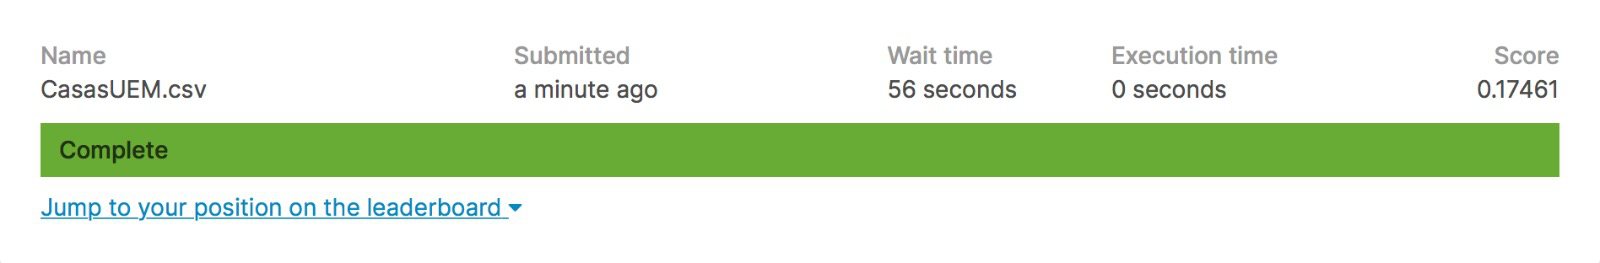

In [73]:
Image.open('./Score.jpeg')

Posición en Kaggle

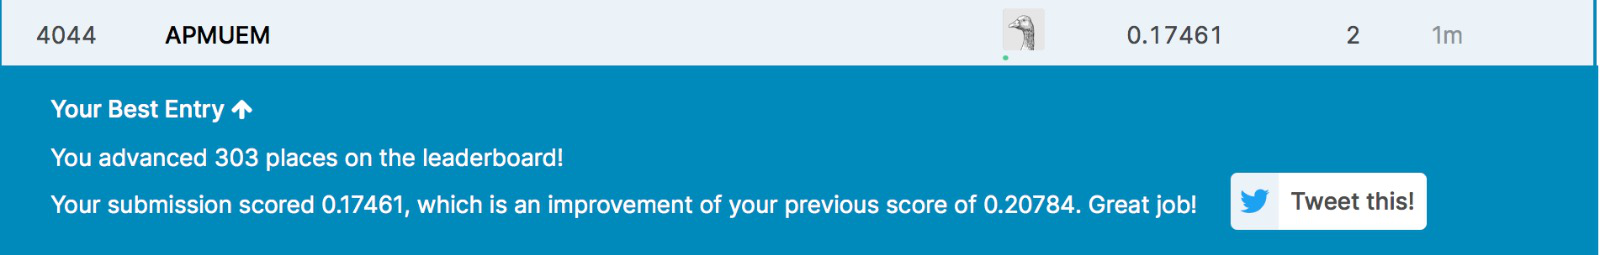

In [74]:
Image.open('./Posicion.jpeg')

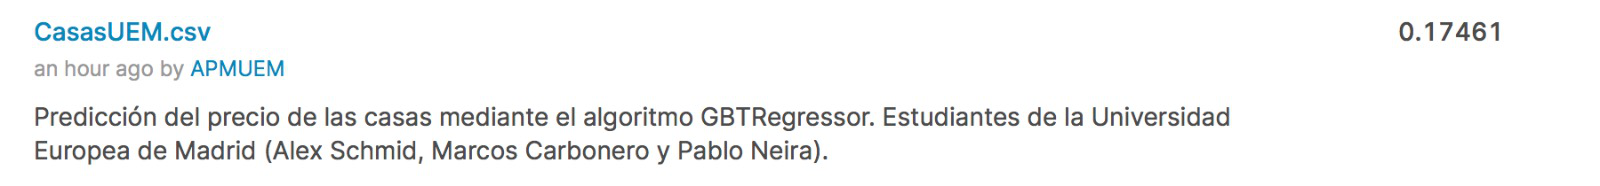

In [75]:
Image.open('./APM.jpeg')

## Comparativa Regresión lineal Pyspark vs Phyton

In [67]:
import numpy as np
import pandas as pd
import seaborn as sb
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [68]:
data = pd.read_csv("./train.csv")

In [69]:
filtered_data = data[(data['SalePrice'] <= 750000) & (data['OverallQual'] >= 1)]
f1 = filtered_data['SalePrice'].values
f2 = filtered_data['OverallQual'].values

In [70]:
suma = (filtered_data["GrLivArea"] + filtered_data['GarageArea'].fillna(0) + filtered_data['TotalBsmtSF'] + filtered_data['1stFlrSF'] + filtered_data['2ndFlrSF'] + filtered_data['YearBuilt'])
 
dataX2 =  pd.DataFrame()
dataX2["OverallQual"] = filtered_data["OverallQual"]
dataX2["suma"] = suma
XY_train = np.array(dataX2)
z_train = filtered_data['SalePrice'].values

In [71]:
# Creamos un nuevo modelo de Regresión Lineal
regr2 = linear_model.LinearRegression()
 
# Entrenamos el modelo, esta vez, con 2 dimensiones
# obtendremos 2 coeficientes, para graficar un plano
regr2.fit(XY_train, z_train)
 
# Hacemos la predicción con la que tendremos puntos sobre el plano hallado
z_pred = regr2.predict(XY_train)
 
# Evaluamos el puntaje de varianza (siendo 1.0 el mejor posible)
print('r2: %.2f' % r2_score(z_train, z_pred))

r2: 0.75


In [72]:
# Si quiero predecir cuántos el mi "sale price" que voy a obtener 
# "OverallQual"= y ,"GrLivArea"=, "GarageArea"=, "TotalBsmtSF"= ,"1stFlrSF"= "2ndFlrSF"= "YearBuilt"=
# según nuestro modelo, hacemos:
#precio real=208500 
z_SalePrice0 = regr2.predict([[7, 1710+548+856+856+854+2003]])
print(int(z_SalePrice0))

212029


In [76]:
# Si quiero predecir cuántos el mi "sale price" que voy a obtener 
# "OverallQual"= y ,"GrLivArea"=, "GarageArea"=, "TotalBsmtSF"= ,"1stFlrSF"= "2ndFlrSF"= "YearBuilt"=
# según nuestro modelo, hacemos:
#precio real= 118.000
z_SalePrice1 = regr2.predict([[5, 1077+205+991+1077+0+1939]])
print(int(z_SalePrice1))

119425


In [77]:
# Si quiero predecir cuántos el mi "sale price" que voy a obtener 
# "OverallQual"= y ,"GrLivArea"=, "GarageArea"=, "TotalBsmtSF"= ,"1stFlrSF"= "2ndFlrSF"= "YearBuilt"=
# según nuestro modelo, hacemos:
#precio real= 250.000
z_SalePrice2 = regr2.predict([[8, 2198+836+1145+1145+1053+2000]])
print(int(z_SalePrice2))

279041


In [90]:
predictionsL.select("prediction", "SalePrice", "features").show(2)

+------------------+---------+--------------------+
|        prediction|SalePrice|            features|
+------------------+---------+--------------------+
|172388.74473247863| 181500.0|[1976.0,1262.0,6....|
|226419.49617906776| 223500.0|[2001.0,920.0,7.0...|
+------------------+---------+--------------------+
only showing top 2 rows



### Comparación directa con la casa ID 1

###### Precio real= 181500


In [92]:

#precio real= 181500
#prediccción modelo Pyspark=172388.744
z_SalePrice2 = regr2.predict([[6, 1262+460+1262+1262+0+ 1976]])
print(int(z_SalePrice2))

170076


######  Prediccción modelo Pyspark=172388.744

### Comparación directa con la casa ID 2

###### Precio real= 223.500


In [78]:

#precio real= 223.500
#prediccción modelo Pyspark=226419.496
z_SalePrice2 = regr2.predict([[7, 1786+608+920+920+866+2001]])
print(int(z_SalePrice2))

219295


###### Prediccción modelo Pyspark=226419.496